In [1]:
from scipy.interpolate import interp1d
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.insert(1, '../ProcessEvents')
from ProcessEventsFunctions import *

def plot_incremental_rainfall(rainfall_array, ax, titles=True, labels=False):
    
    # Define custom labels for the bars
    bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

    # Define the color mapping
    color_mapping = {
        'F2': (0.0, 0.0, 1.0, 0.6),'F1': (0.0, 0.6902, 1.0, 0.6),'C': (0.5, 0.5, 0.5, 0.6),'B1': (0.8039, 0.0, 0.0, 0.6),   
        'B2': (0.5451, 0.0, 0.0, 0.6) }

    # Find the index of the maximum value
    index_of_max = np.argmax(rainfall_array)

    # Initialize all bars with a default color (e.g., white or light gray)
    colors = ['white'] * len(rainfall_array)  # Default color for all bars

    # Apply the color from the color_mapping to the bar at index_of_max
    colors[index_of_max] = color_mapping[bar_labels[index_of_max]]

    # Create the bar chart
    time_steps = np.arange(1, len(rainfall_array) + 1)
    ax.bar(time_steps, rainfall_array, label='Incremental Rainfall', color=colors, edgecolor='black')

    # Set custom labels on the x-axis
    ax.set_xticks(time_steps, bar_labels)
    
    ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if titles == True:
        ax.set_title('Rainfall accumulations (5 bins)', fontsize=15)
    if labels:
        ax.set_xlabel('Quintile class', fontsize=15)
    ax.grid('off');
    
def make_roberto_plot(sample, axs, titles=True, labels=True):
    
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
    dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    x_ticks = np.array(range(1, len(sample) + 1)) * 0.5  # [0.5, 1.0, 1.5]
    
    # 1. Raw Data Plot
    axs[0].bar(np.array(range(1, len(sample) + 1)) * 0.5, sample, color='royalblue', alpha=0.7, width=0.4)

    axs[0].set_ylabel('Rainfall (mm)', fontsize=15)
    # axs[0].set_xticks(x_ticks)
    
    # 2. Dimensionless Cumulative Values
    time_percentage = (np.arange(0, len(sample) + 1) / len(sample)) * 100  
        
    axs[1].plot(time_percentage, dimensionless_cumulative_rainfall, 
                label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

    # Plot horizontal line for the corresponding sample value
    percentile = 0.5
    total_duration = len(sample) * 0.5  # 1.5 hours
    axs[1].axhline(y=percentile, color='black', linestyle='--', label=f'{percentile}th Percentile')
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    # Find intersection point for percentile line
    indices_below = np.where(dimensionless_cumulative_rainfall < percentile)[0]
    indices_above = np.where(dimensionless_cumulative_rainfall >= percentile)[0]
    
    if len(indices_below) > 0 and len(indices_above) > 0:
        index_below = indices_below[-1]
        index_above = indices_above[0]
        
        # Interpolation to find intersection
        x_below = time_percentage[index_below]
        y_below = dimensionless_cumulative_rainfall[index_below]
        x_above = time_percentage[index_above]
        y_above = dimensionless_cumulative_rainfall[index_above]
        slope = (y_above - y_below) / (x_above - x_below)
        time_for_percentile = x_below + (percentile - y_below) / slope
        
        axs[1].axvline(x=time_for_percentile, color='red', linestyle='-', linewidth=3)
        axs[1].annotate(f'D50: {time_for_percentile:.1f}%', 
                        xy=(time_for_percentile, percentile), 
                        xytext=(time_for_percentile, percentile  - 0.4),  
                        arrowprops=dict(facecolor='black', arrowstyle='->'),   
                        fontsize=16)

    # 3. Interpolated Cumulative Values
    interpolated_n_times_percentage = interpolated_n_times * 100 
    axs[2].plot(interpolated_n_times_percentage, interpolated_n_cumulative_rainfall, label='Cumulative Sum',linewidth=2,  marker='o', 
                color='royalblue', markersize=8, markerfacecolor='magenta')

    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_xlim(0, 100)

    # Call the function for the last subplot
    plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[3], titles, labels)

    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)  # Adjust labelsize as needed
     
    axs[1].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    
    if labels == True:
        axs[0].set_xlabel('Time (hours)', fontsize=15) 
        axs[1].set_xlabel('Proportion of duration', fontsize=15)  
        axs[2].set_xlabel('Proportion of duration', fontsize=15)    
        
        
    if titles:
        axs[0].set_title('Raw rainfall (mm)', fontsize=15)        
        axs[2].set_title('Dimensionless cumulative rainfall \n interpolated to len 5', fontsize=15)        
        axs[1].set_title('Dimensionless cumulative rainfall, \n with linearly interpolated lines', fontsize=15)  

## Get some sample data

In [2]:
n=5

In [3]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [4]:
time_period='Future'
gauge_num=1
em = 'bb189'
indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/"

files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
files = np.sort(files)

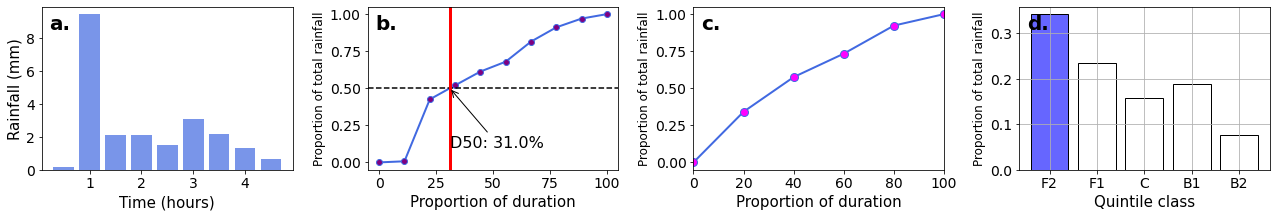

In [22]:
sample1 = pd.read_csv(indy_events_fp + files[9])['precipitation (mm)']

fig, axs = plt.subplots(1, 4, figsize=(22, 3))  
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
make_roberto_plot(sample1, axs, titles=False, labels = True)  # Third row for sample3
labels = ['a.', 'b.', 'c.', 'd.']
for ax, label in zip(axs.flat, labels):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
fig.savefig("../AnalyseProfiles/Figs/methods_event1.png", dpi=200, bbox_inches='tight')     

In [170]:
sample = pd.read_csv(indy_events_fp + files[9])['precipitation (mm)']
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, 5)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)

Text(0, 0.5, 'Cumulative Precipitation')

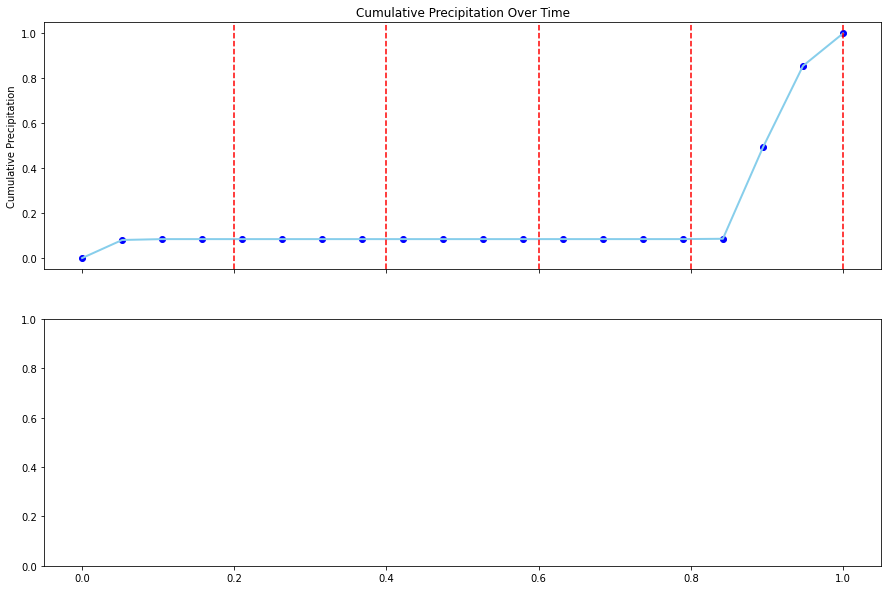

In [208]:
def create_split_fifths(cumulative_precip, dimensionless_times):
    # 3. Define time intervals (30-minute intervals)
    total_duration = dimensionless_times[-1] 
    # 4. Define boundaries for the five equal time segments (0, T/5, 2T/5, ..., T)
    boundaries = np.linspace(0, total_duration, 6)  # 6 boundaries -> 5 segments    
    # 5. Interpolate cumulative precipitation at these boundary times
    interp_cum = np.interp(boundaries, time_intervals, cumulative_precip)    
    # 6. Compute the precipitation in each fifth (difference between consecutive boundaries)
    precip_in_fifths = np.diff(interp_cum)
        
    return precip_in_fifths, boundaries

def create_split_fifths_manual(cumulative_precip, dimensionless_times):
    """
    Given the cumulative precipitation (assumed to include an initial 0) and the
    corresponding time values (dimensionless_times), this function splits the event
    into 5 equal time segments and computes the rainfall in each segment by manually
    summing the contributions from each measurement interval.
    
    Parameters:
        cumulative_precip : array-like
            Cumulative precipitation values (starting with 0).
        dimensionless_times : array-like
            Times corresponding to the cumulative values.
    
    Returns:
        precip_in_fifths : numpy array of length 5
            The precipitation in each fifth of the event.
        boundaries : numpy array of length 6
            The time boundaries defining the 5 segments.
    """
    # Total duration is the last time point.
    total_duration = dimensionless_times[-1]
    
    # Define boundaries for five equal segments.
    boundaries = np.linspace(0, total_duration, 6)  # [T0, T1, ..., T5]
    
    # Compute the incremental rainfall for each interval.
    # Assumes cumulative_precip already has an initial 0. If not, uncomment the following:
    # if cumulative_precip[0] != 0:
    #     cumulative_precip = np.insert(cumulative_precip, 0, 0)
    incremental_rainfall = np.diff(cumulative_precip)
    
    # Initialize array to hold the rainfall in each fifth.
    precip_in_fifths = np.zeros(5)
    
    # We'll treat each measurement interval as going from:
    #   prev_time (start) to end_time (from dimensionless_times)
    prev_time = 0
    for i, end_time in enumerate(dimensionless_times):
        rain = incremental_rainfall[i]
        interval_duration = end_time - prev_time
        # For each segment, calculate how much of this measurement interval overlaps.
        for seg in range(5):
            seg_start = boundaries[seg]
            seg_end = boundaries[seg + 1]
            # Determine the overlap between the measurement interval and this segment.
            overlap_start = max(prev_time, seg_start)
            overlap_end = min(end_time, seg_end)
            overlap = max(0, overlap_end - overlap_start)
            if interval_duration > 0:
                # Allocate proportionally the rainfall from this interval.
                precip_in_fifths[seg] += (overlap / interval_duration) * rain
        prev_time = end_time

    return precip_in_fifths, boundaries


# def plot_split_fifths():
    

# def plot_split_fifths(ax, boundaries,precip_in_fifths):
#     # Plot 2: Precipitation in Each Fifth of the Event
#     for i in range(5):
#         start_time = boundaries[i]
#         end_time = boundaries[i+1]
#         value = precip_in_fifths[i]
#         # Draw a horizontal bar spanning the time segment
#         ax.barh(y=1, width=end_time - start_time, left=start_time, height=0.5, color='lightgreen', edgecolor='black')
#         # Label the bar with the precipitation amount for that segment
#         ax.text((start_time + end_time) / 2, 1, f'{value:.2f}', ha='center', va='center', fontsize=8)
    
sample = pd.read_csv(indy_events_fp + files[3])['precipitation (mm)']
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
precip_in_fifths, boundaries = create_split_fifths(dimensionless_cumulative_rainfall, dimensionless_times)


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Cumulative Precipitation Over Time (continuous line)
axs[0].plot(dimensionless_times, cumulative_precip, color='skyblue', linewidth=2, label='Cumulative Precipitation')
for marker in boundaries[1:]:
    axs[0].axvline(marker, color='red', linestyle='--', label='Fifth Boundary' if marker==boundaries[1] else "")
axs[0].scatter(normalized_time_intervals, cumulative_precip, color='blue')
axs[0].set_title('Cumulative Precipitation Over Time')
axs[0].set_ylabel('Cumulative Precipitation')

# axs[0].set_xticks(np.arange(0, dimensionless_times[-1] + 5, 5))
# axs[0].set_xticklabels(np.arange(0, dimensionless_times[-1] + 5, 5), rotation=90)

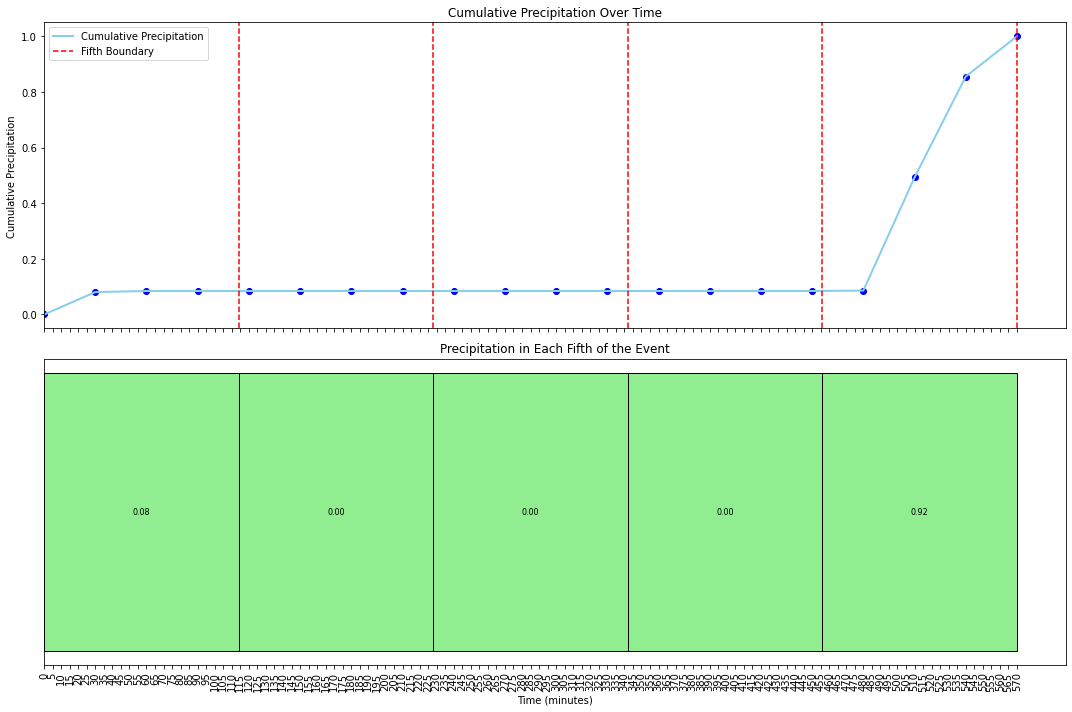

In [186]:
sample = pd.read_csv(indy_events_fp + files[3])['precipitation (mm)']
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)

# 2. Calculate cumulative precipitation and add initial 0 at time 0
cumulative_precip = dimensionless_cumulative_rainfall

# # 3. Define time intervals (30-minute intervals)
time_intervals = np.arange(0, 30 * len(cumulative_precip), 30)
total_duration = time_intervals[-1]  # e.g., 270 minutes

# # 4. Define boundaries for the five equal time segments (0, T/5, 2T/5, ..., T)
# boundaries = np.linspace(0, total_duration, 6)  # 6 boundaries -> 5 segments

# # 5. Interpolate cumulative precipitation at these boundary times
# interp_cum = np.interp(boundaries, time_intervals, cumulative_precip)

# 6. Compute the precipitation in each fifth (difference between consecutive boundaries)
# precip_in_fifths = np.diff(interp_cum)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Cumulative Precipitation Over Time (continuous line)
axs[0].plot(time_intervals, cumulative_precip, color='skyblue', linewidth=2, label='Cumulative Precipitation')
axs[0].scatter(time_intervals, cumulative_precip, color='blue')
axs[0].set_title('Cumulative Precipitation Over Time')
axs[0].set_ylabel('Cumulative Precipitation')

# Optionally, draw vertical lines at the fifth boundaries (excluding the first and last)
for marker in boundaries[1:]:
    axs[0].axvline(marker, color='red', linestyle='--', label='Fifth Boundary' if marker==boundaries[1] else "")

axs[0].set_xticks(np.arange(0, total_duration + 5, 5))
axs[0].set_xticklabels(np.arange(0, total_duration + 5, 5), rotation=90)
axs[0].legend()

precip_in_fifths, boundaries = create_split_fifths(cumulative_precip)
plot_split_fifths(axs[1], boundaries, precip_in_fifths)

# # Plot 2: Precipitation in Each Fifth of the Event
# for i in range(5):
#     start_time = boundaries[i]
#     end_time = boundaries[i+1]
#     value = precip_in_fifths[i]
#     # Draw a horizontal bar spanning the time segment
#     axs[1].barh(y=1, width=end_time - start_time, left=start_time, height=0.5, color='lightgreen', edgecolor='black')
#     # Label the bar with the precipitation amount for that segment
#     axs[1].text((start_time + end_time) / 2, 1, f'{value:.2f}', ha='center', va='center', fontsize=8)

# # Draw vertical lines at the fifth boundaries
# for marker in boundaries[1:-1]:
#     axs[1].axvline(marker, color='red', linestyle='--')

axs[1].set_title('Precipitation in Each Fifth of the Event')
axs[1].set_xlabel('Time (minutes)')
axs[1].set_yticks([])

axs[1].set_xticks(np.arange(0, total_duration + 5, 5))
axs[1].set_xticklabels(np.arange(0, total_duration + 5, 5), rotation=90)

plt.tight_layout()
plt.show()


In [150]:
sample1 = pd.read_csv(indy_events_fp + files[9])['precipitation (mm)']
sample1_df=pd.DataFrame({'times': range(30,len(sample1)*30+30,30), 'precip': sample1.values})

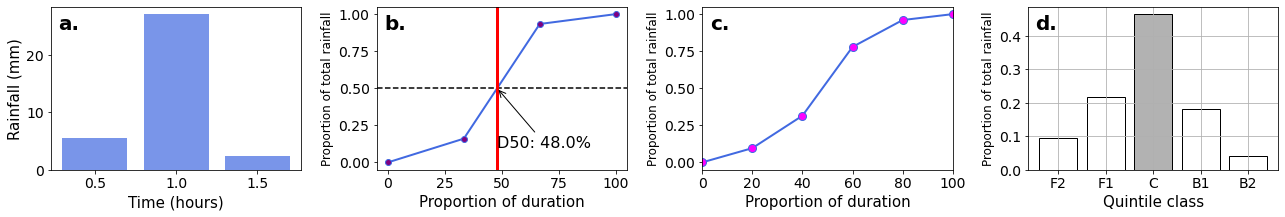

In [6]:
sample2 = pd.read_csv(indy_events_fp + files[1])['precipitation (mm)']

fig, axs = plt.subplots(1, 4, figsize=(22, 3))  
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
make_roberto_plot(sample2, axs, titles=False, labels = True)  # Third row for sample3
labels = ['a.', 'b.', 'c.', 'd.']
for ax, label in zip(axs.flat, labels):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
fig.savefig("../AnalyseProfiles/Figs/methods_event2.png", dpi=200, bbox_inches='tight')     

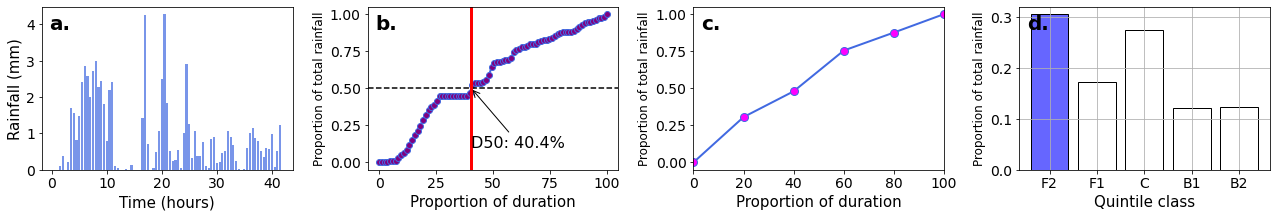

In [7]:
sample3 = pd.read_csv(indy_events_fp + files[29])['precipitation (mm)']

fig, axs = plt.subplots(1, 4, figsize=(22, 3))  
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
make_roberto_plot(sample3, axs, titles=False, labels = True)  # Third row for sample3
labels = ['a.', 'b.', 'c.', 'd.']
for ax, label in zip(axs.flat, labels):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
fig.savefig("../AnalyseProfiles/Figs/methods_event3.png", dpi=200, bbox_inches='tight')     

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

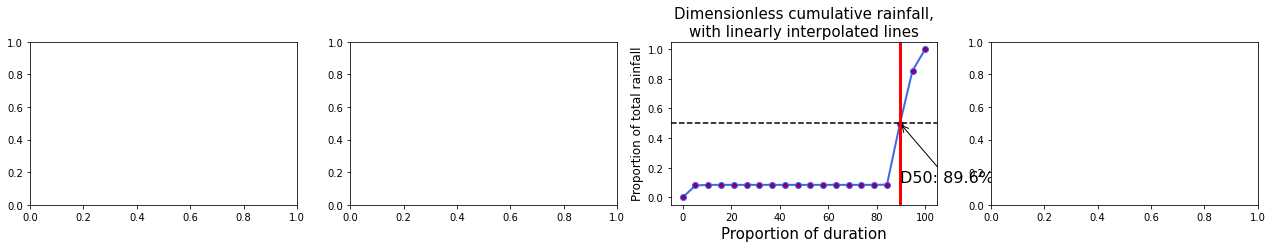

In [211]:
def plot_dimensionless_cumulative(sample, dimensionless_cumulative_rainfall, ax, labels=True, title=True):
    """
    Plot the dimensionless cumulative rainfall.
    """
    # Create a percentage scale for the duration.
    time_percentage = (np.arange(0, len(sample) + 1) / len(sample)) * 100

    ax.plot(time_percentage, dimensionless_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')
    
    # Plot a horizontal line at 0.5 (50% of total rainfall) for reference.
    percentile = 0.5
    ax.axhline(y=percentile, color='black', linestyle='--', label=f'{percentile}th Percentile')
    
    # Find and mark the time at which the cumulative value crosses the 50% mark.
    indices_below = np.where(dimensionless_cumulative_rainfall < percentile)[0]
    indices_above = np.where(dimensionless_cumulative_rainfall >= percentile)[0]
    if len(indices_below) > 0 and len(indices_above) > 0:
        index_below = indices_below[-1]
        index_above = indices_above[0]
        x_below = time_percentage[index_below]
        y_below = dimensionless_cumulative_rainfall[index_below]
        x_above = time_percentage[index_above]
        y_above = dimensionless_cumulative_rainfall[index_above]
        slope = (y_above - y_below) / (x_above - x_below)
        time_for_percentile = x_below + (percentile - y_below) / slope
        
        ax.axvline(x=time_for_percentile, color='red', linestyle='-', linewidth=3)
        ax.annotate(f'D50: {time_for_percentile:.1f}%', 
                    xy=(time_for_percentile, percentile), 
                    xytext=(time_for_percentile, percentile - 0.4),  
                    arrowprops=dict(facecolor='black', arrowstyle='->'),   
                    fontsize=16)
    
    if labels:
        ax.set_xlabel('Proportion of duration', fontsize=15)
        ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if title:
        ax.set_title('Dimensionless cumulative rainfall,\nwith linearly interpolated lines', fontsize=15)
        
        
def plot_interpolated_cumulative(interpolated_n_cumulative_rainfall, interpolated_n_times, ax, labels=True, title=True):
    """
    Plot the interpolated cumulative rainfall.
    """
    # Convert the time to percentage
    interpolated_n_times_percentage = interpolated_n_times * 100 
    ax.plot(interpolated_n_times_percentage, interpolated_n_cumulative_rainfall, label='Cumulative Sum', 
            linewidth=2, marker='o', color='royalblue', markersize=8, markerfacecolor='magenta')
    ax.set_xlim(0, 100)
    
    if labels:
        ax.set_xlabel('Proportion of duration', fontsize=15)
        ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if title:
        ax.set_title('Dimensionless cumulative rainfall\ninterpolated to len 5', fontsize=15)

cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
        
fig, axs = plt.subplots(1, 4, figsize=(22, 3))  
plot_dimensionless_cumulative(sample,dimensionless_cumulative_rainfall,axs[2] )
plot_dimensionless_cumulative(interpolated_n_cumulative_rainfall, interpolated_n_times,axs[3] )

2


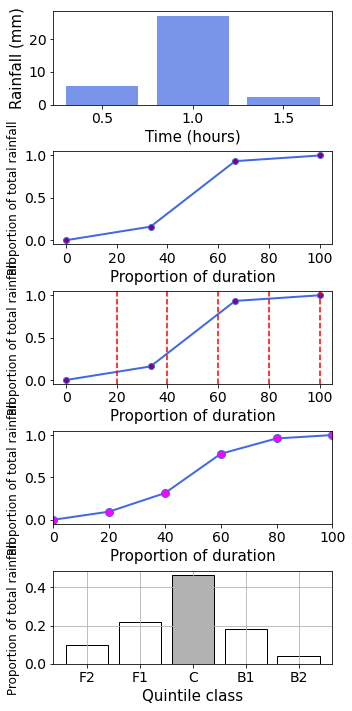

In [261]:
def plot_raw_data(sample, ax, labels=True, title=False):
    """
    Plot the raw rainfall data.
    """
    # x values: each measurement is taken at a 0.5-hour interval.
    x_values = np.array(range(1, len(sample) + 1)) * 0.5
    ax.bar(x_values, sample, color='royalblue', alpha=0.7, width=0.4)
    
    if labels:
        ax.set_xlabel('Time (hours)', fontsize=15)
        ax.set_ylabel('Rainfall (mm)', fontsize=15)
    if title:
        ax.set_title('Raw rainfall (mm)', fontsize=15)


def plot_dimensionless_cumulative(raw_rainfall, dimensionless_cumulative_rainfall, ax, boundaries_boolean = False, labels=True, title=False):
    """
    Plot the dimensionless cumulative rainfall.
    """
    # Create a percentage scale for the duration.
    time_percentage = (np.arange(0, len(raw_rainfall) + 1) / len(raw_rainfall)) * 100
    
    # Define time intervals
    total_duration = time_percentage[-1]  # e.g., 270 minutes
    boundaries = np.linspace(0, total_duration, 6)  # 6 boundaries -> 5 segments
    
    ax.plot(time_percentage, dimensionless_cumulative_rainfall, 
            label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')
    
    if boundaries_boolean ==True:
        for marker in boundaries[1:]:
            ax.axvline(marker, color='red', linestyle='--', label='Fifth Boundary' if marker==boundaries[1] else "")
    
    if labels:
        ax.set_xlabel('Proportion of duration', fontsize=15)
        ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if title:
        ax.set_title('Dimensionless cumulative rainfall,\nwith linearly interpolated lines', fontsize=15)


def plot_interpolated_cumulative(interpolated_n_cumulative_rainfall, interpolated_n_times, ax, labels=True, title=False):
    """
    Plot the interpolated cumulative rainfall.
    """
    # Convert the time to percentage
    interpolated_n_times_percentage = interpolated_n_times * 100 
    ax.plot(interpolated_n_times_percentage, interpolated_n_cumulative_rainfall, label='Cumulative Sum', 
            linewidth=2, marker='o', color='royalblue', markersize=8, markerfacecolor='magenta')
    ax.set_xlim(0, 100)
    
    if labels:
        ax.set_xlabel('Proportion of duration', fontsize=15)
        ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if title:
        ax.set_title('Dimensionless cumulative rainfall\ninterpolated to len 5', fontsize=15)

def plot_incremental_rainfall(rainfall_array, ax, titles=False, labels=False):
    
    # Define custom labels for the bars
    bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

    # Define the color mapping
    color_mapping = {
        'F2': (0.0, 0.0, 1.0, 0.6),'F1': (0.0, 0.6902, 1.0, 0.6),'C': (0.5, 0.5, 0.5, 0.6),'B1': (0.8039, 0.0, 0.0, 0.6),   
        'B2': (0.5451, 0.0, 0.0, 0.6) }

    # Find the index of the maximum value
    index_of_max = np.argmax(rainfall_array)
    print(index_of_max)

    # Initialize all bars with a default color (e.g., white or light gray)
    colors = ['white'] * len(rainfall_array)  # Default color for all bars

    # Apply the color from the color_mapping to the bar at index_of_max
    colors[index_of_max] = color_mapping[bar_labels[index_of_max]]

    # Create the bar chart
    time_steps = np.arange(1, len(rainfall_array) + 1)
    ax.bar(time_steps, rainfall_array, label='Incremental Rainfall', color=colors, edgecolor='black')

    # Set custom labels on the x-axis
    ax.set_xticks(time_steps, bar_labels)
    
    ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if titles == True:
        ax.set_title('Rainfall accumulations (5 bins)', fontsize=15)
    if labels:
        ax.set_xlabel('Quintile class', fontsize=15)
    ax.grid('off');

        
fig, axs = plt.subplots(5, 1, figsize=(5, 12))  
plt.subplots_adjust(hspace=0.5)

n=5

sample1 = pd.read_csv(indy_events_fp + files[1])['precipitation (mm)']
sample=sample1

# Generate the various processed data.
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample1)
dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)

# Plot each element in its own axis.
plot_raw_data(sample, axs[0], labels=labels)
plot_dimensionless_cumulative(sample, dimensionless_cumulative_rainfall, axs[1], False)
plot_dimensionless_cumulative(sample, dimensionless_cumulative_rainfall, axs[2], boundaries_boolean =True)
plot_interpolated_cumulative(interpolated_n_cumulative_rainfall, interpolated_n_times, axs[3], labels=labels)
plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[4], labels=labels)

# Adjust tick parameters for all subplots.
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)


In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def split_rainfall_manual(ts, num):
    """
    Splits a rainfall timeseries (ts) into num equal‐time segments by manually summing
    the rainfall in each segment. It assumes that the rainfall recorded in each interval 
    (from one timestamp to the next) accumulates uniformly.
    
    Parameters:
        ts  : pandas Series with a DateTimeIndex (rainfall values)
        num : integer, number of segments to split the time series into.
        
    Returns:
        sums       : list of rainfall sums for each segment.
        boundaries : pandas DatetimeIndex of split boundaries.
    """
    # Determine the fixed measurement interval (in seconds)
    dt = (ts.index[1] - ts.index[0]).total_seconds()
    
    # Define the full period covered by the timeseries.
    # We assume that each measurement covers the interval [t, t+dt)
    t0 = ts.index[0]
    t_end = ts.index[-1] + pd.Timedelta(seconds=dt)
    
    # Create the boundary timestamps that split the period into 'num' equal segments.
    boundaries = pd.date_range(start=t0, end=t_end, periods=num+1)
    
    # For each segment, sum the rainfall by allocating a fraction of each measurement
    # if its interval overlaps the segment.
    sums = []
    for i in range(num):
        seg_start = boundaries[i]
        seg_end   = boundaries[i+1]
        seg_sum = 0.0
        
        # Loop over each measurement interval.
        for j in range(len(ts)):
            interval_start = ts.index[j]
            interval_end   = interval_start + pd.Timedelta(seconds=dt)
            
            # Find the overlap (in seconds) between the measurement interval and the segment.
            overlap_start = max(interval_start, seg_start)
            overlap_end   = min(interval_end, seg_end)
            overlap = (overlap_end - overlap_start).total_seconds()
            
            if overlap > 0:
                fraction = overlap / dt
                seg_sum += ts.iloc[j] * fraction
        sums.append(seg_sum)
        
    return sums, boundaries


# ---------------------------
# Example usage and plotting
# ---------------------------
# Create an example rainfall timeseries.
# Let's assume measurements every 5 minutes for 2 hours.
rng = pd.date_range('2025-01-01 00:00:00', periods=24, freq='5min')
# For demonstration, let the rainfall be a random value (e.g., in mm) at each interval.
np.random.seed(0)
rainfall = sample

# Split the timeseries into 4 equal segments.
num_segments = 4
segment_sums, boundaries = split_rainfall_manual(ts, num_segments)

# Plot the original rainfall timeseries
plt.figure(figsize=(15, 7))
plt.bar(ts.index, ts.values, width=(ts.index[1]-ts.index[0]), 
        align='edge', alpha=0.7, label='Rainfall (mm)')

# Plot vertical lines for the split boundaries.
for b in boundaries:
    plt.axvline(b, color='red', linestyle='--', label='Split boundary' if b == boundaries[0] else None)

# Annotate each segment with its computed sum.
for i in range(num_segments):
    mid_point = boundaries[i] + (boundaries[i+1] - boundaries[i]) / 2
    plt.text(mid_point, max(ts.values)*0.9, f"{segment_sums[i]:.2f}",
             horizontalalignment='center', fontsize=12, color='black')

plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.title("Rainfall Timeseries with Split Boundaries and Segment Sums")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'ts' is not defined